In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 12.3 MB/s 
     |████████████████████████████████| 895 kB 54.5 MB/s 
     |████████████████████████████████| 596 kB 50.1 MB/s 
     |████████████████████████████████| 3.3 MB 56.8 MB/s 
     |████████████████████████████████| 59 kB 9.0 MB/s 
     |████████████████████████████████| 1.2 MB 15.3 MB/s 


In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
from IPython.display import display, HTML

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [6]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [20]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(2814+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [8]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [9]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [10]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        average='binary', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average,
                                                      pos_label=pos_label))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average, pos_label=pos_label))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average, pos_label=pos_label))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average,
                                                           pos_label=pos_label))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average,
                                                     pos_label=pos_label))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average, pos_label=pos_label))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    return results

In [11]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [12]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [13]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [14]:
def train_model(data, sequences, masks, transformer, gpu, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'train_precision': [],
            'validation_precision': [],
            'train_recall': [],
            'validation_recall': [],
            'train_labels': [],
            'validation_labels': [],
            'train_predictions': [],
            'validation_predictions': []
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    return results

In [15]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_chroma.pkl')
labels = torch.tensor(data['iGenre'].tolist())
txt = list(data.apply(lambda x: x.Lyric, axis=1))

In [16]:
data['iGenre'].value_counts()

1    794
0    345
Name: iGenre, dtype: int64

In [17]:
res_tbl_keys = ['train_f1','validation_f1','train_precision','validation_precision','train_recall','validation_recall']

## Indic BERT Multi Modal

In [18]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/IndicBERT_FineTuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.576 / Validation Loss : 0.488 [Time : 11.49322 seconds]
Epoch 2/5 : Training Loss: 0.456 / Validation Loss : 0.405 [Time : 11.460365 seconds]
Epoch 3/5 : Training Loss: 0.421 / Validation Loss : 0.397 [Time : 11.473562 seconds]
Epoch 4/5 : Training Loss: 0.405 / Validation Loss : 0.373 [Time : 11.465479 seconds]
Epoch 5/5 : Training Loss: 0.419 / Validation Loss : 0.371 [Time : 11.49721 seconds]
*** Confusion Matrix - Training ***
[[237  39]
 [145 490]]
*** Confusion Matrix - Validation ***
[[231  45]
 [ 58 577]]
Fold 1 : 57.462876 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.527 / Validation Loss : 0.412 [Time : 11.149801 seconds]
Epoch 2/5 : Training Loss: 0.372 / Validation Loss : 0.351 [Time : 11.592804 seconds]
Epoch 3/5 : Training Loss: 0.339 / Validation Loss : 0.312 [Time : 11.466889 seconds]
Epoch 4/5 : Training Loss: 0.

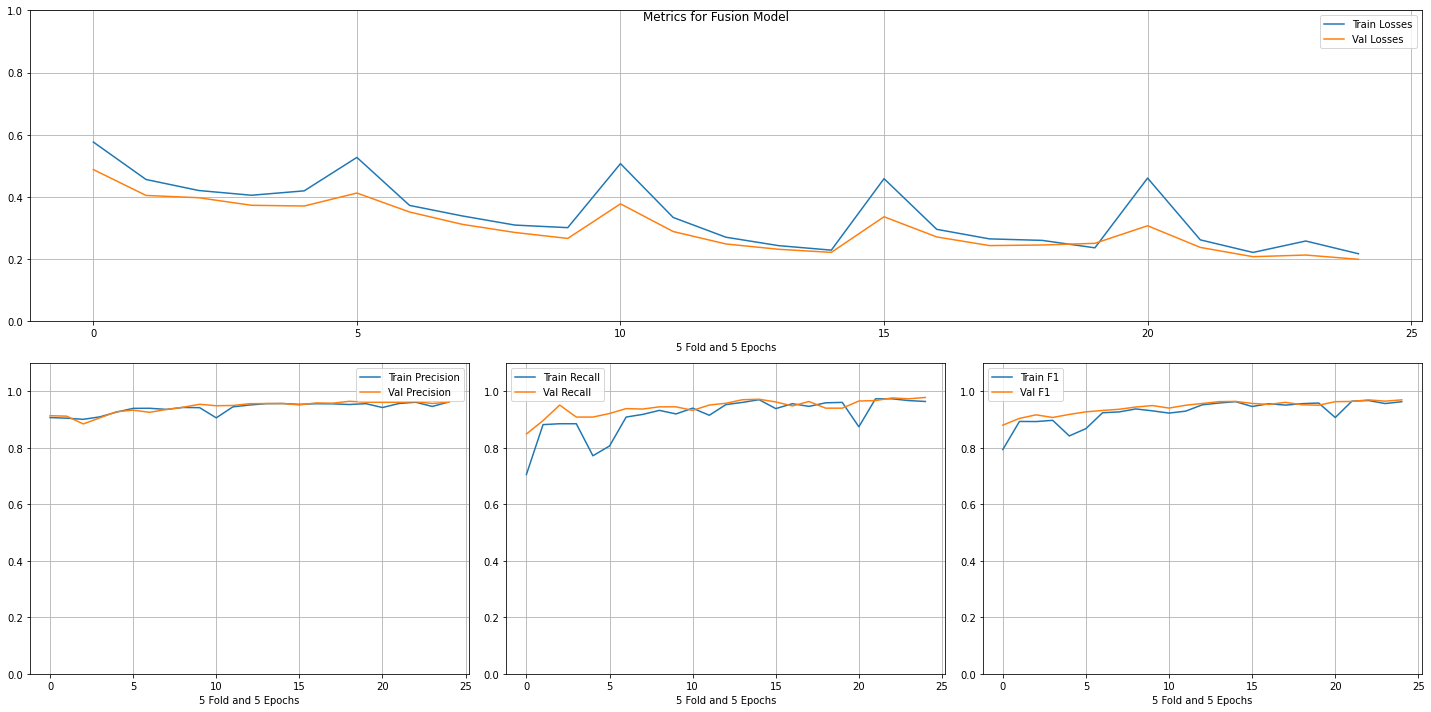

In [21]:
indic_bert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='chroma', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5, fsize=(12,1876))

In [22]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
4,0.963079,0.969602,0.962323,0.961360,0.963836,0.977987
2,0.967187,0.969555,0.961180,0.962791,0.973270,0.976415
3,0.956454,0.964926,0.946154,0.956723,0.966981,0.973270
4,0.963253,0.964062,0.956522,0.956589,0.970079,0.971654
1,0.964926,0.963950,0.956723,0.960938,0.973270,0.966981
3,0.958366,0.963253,0.956113,0.956522,0.960630,0.970079
0,0.907015,0.963137,0.942373,0.960876,0.874214,0.965409
2,0.950949,0.960754,0.955485,0.957746,0.946457,0.963780
0,0.946032,0.956930,0.953600,0.951713,0.938583,0.962205
2,0.952006,0.956727,0.951258,0.955975,0.952756,0.957480


## MURIL Multi Modal

In [23]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/MURIL_FineTuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.631 / Validation Loss : 0.566 [Time : 16.078692 seconds]
Epoch 2/5 : Training Loss: 0.534 / Validation Loss : 0.460 [Time : 16.254831 seconds]
Epoch 3/5 : Training Loss: 0.434 / Validation Loss : 0.384 [Time : 16.194329 seconds]
Epoch 4/5 : Training Loss: 0.379 / Validation Loss : 0.321 [Time : 16.182146 seconds]
Epoch 5/5 : Training Loss: 0.323 / Validation Loss : 0.283 [Time : 16.285623 seconds]
*** Confusion Matrix - Training ***
[[252  24]
 [ 56 579]]
*** Confusion Matrix - Validation ***
[[253  23]
 [ 44 591]]
Fold 1 : 81.812982 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.603 / Validation Loss : 0.518 [Time : 12.391028 seconds]
Epoch 2/5 : Training Loss: 0.479 / Validation Loss : 0.399 [Time : 12.394689 seconds]
Epoch 3/5 : Training Loss: 0.378 / Validation Loss : 0.321 [Time : 12.358799 seconds]
Epoch 4/5 : Training Loss: 

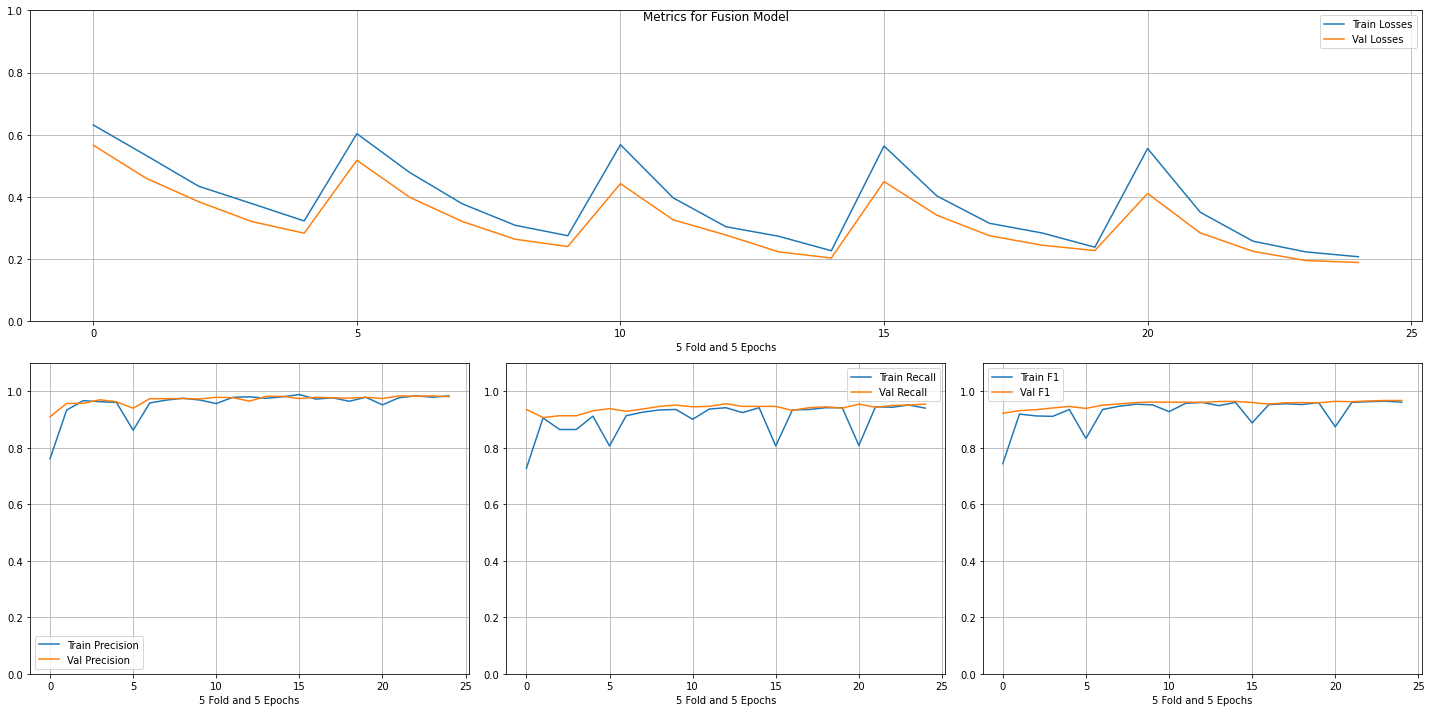

In [24]:
muril_bert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='chroma', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5, fsize=(12,1876))

In [25]:
display(HTML(results_to_df(muril_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
4,0.961415,0.967331,0.983553,0.980614,0.940252,0.954403
3,0.964912,0.967226,0.978964,0.983740,0.951258,0.951258
2,0.963082,0.965627,0.983607,0.982114,0.943396,0.949686
0,0.874150,0.964257,0.951852,0.974318,0.808176,0.954403
4,0.960643,0.963913,0.980328,0.982026,0.941732,0.946457
3,0.949070,0.963913,0.975083,0.982026,0.924409,0.946457
1,0.960831,0.963082,0.977236,0.983607,0.944969,0.943396
4,0.951923,0.961783,0.969005,0.972625,0.935433,0.951181
1,0.957361,0.961600,0.978618,0.977236,0.937008,0.946457
0,0.927818,0.961538,0.956522,0.978793,0.900787,0.944882


## XLMR Multi Modal

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.530 / Validation Loss : 0.410 [Time : 17.186469 seconds]
Epoch 2/5 : Training Loss: 0.384 / Validation Loss : 0.339 [Time : 17.359751 seconds]
Epoch 3/5 : Training Loss: 0.349 / Validation Loss : 0.316 [Time : 17.312316 seconds]
Epoch 4/5 : Training Loss: 0.321 / Validation Loss : 0.327 [Time : 12.564189 seconds]
Epoch 5/5 : Training Loss: 0.305 / Validation Loss : 0.313 [Time : 17.24562 seconds]
*** Confusion Matrix - Training ***
[[244  32]
 [ 60 575]]
*** Confusion Matrix - Validation ***
[[229  47]
 [ 29 606]]
Fold 1 : 82.108589 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.466 / Validation Loss : 0.320 [Time : 12.563374 seconds]
Epoch 2/5 : Training Loss: 0.306 / Validation Loss : 0.339 [Time : 12.542908 seconds]
Epoch 3/5 : Training Loss: 0.319 / Validation Loss : 0.275 [Time : 17.323071 seconds]
Epoch 4/5 : Training Loss: 0

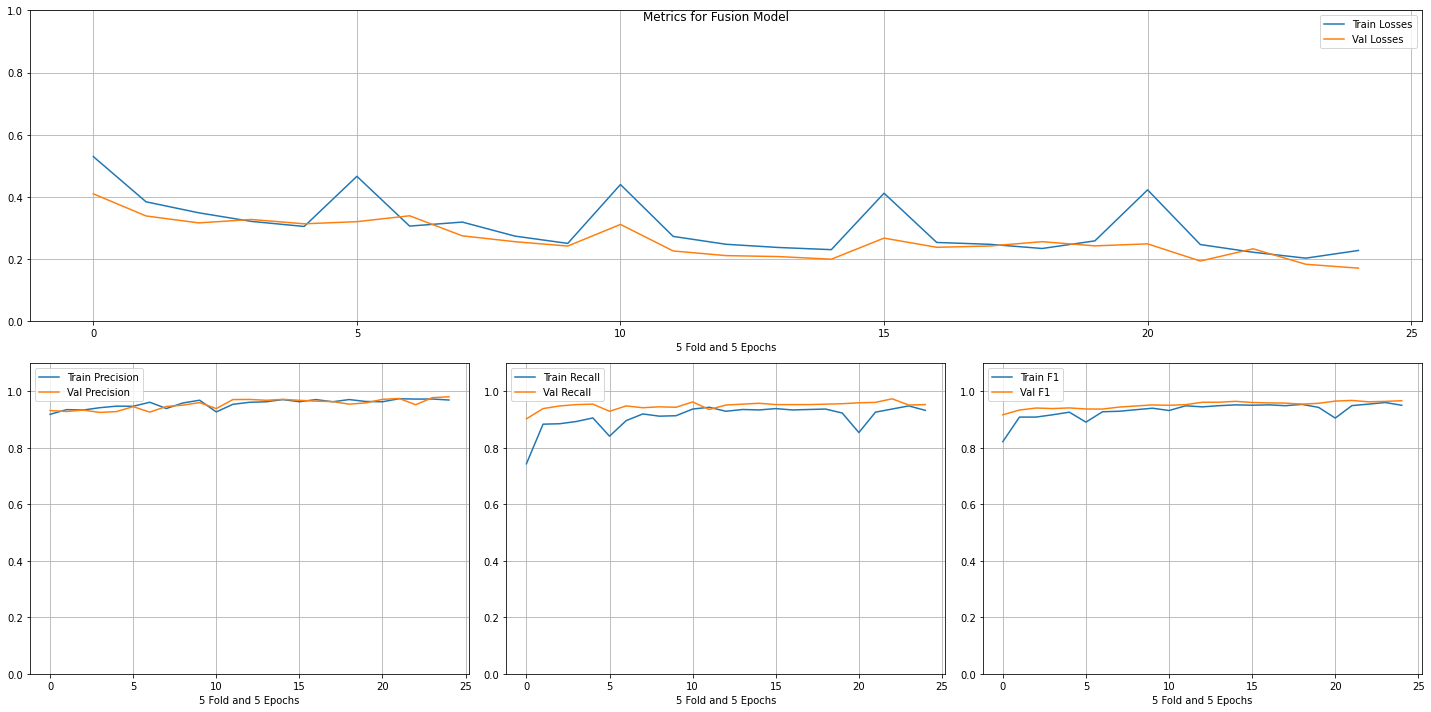

In [26]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/XLMR_Finetuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])
xlmr_bert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='chroma', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5, fsize=(12,1876))

In [27]:
display(HTML(results_to_df(xlmr_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
1,0.949234,0.967538,0.973554,0.974482,0.926101,0.960692
4,0.950321,0.966507,0.968954,0.980583,0.932390,0.952830
0,0.905000,0.965190,0.962766,0.971338,0.853774,0.959119
4,0.951846,0.964314,0.970540,0.971246,0.933858,0.957480
3,0.960191,0.964143,0.972581,0.977383,0.948113,0.951258
2,0.954363,0.962675,0.972268,0.952308,0.937107,0.973270
3,0.948882,0.961142,0.962723,0.968051,0.935433,0.954331
2,0.944756,0.961018,0.960912,0.971061,0.929134,0.951181
0,0.950558,0.960317,0.962843,0.968000,0.938583,0.952756
1,0.951846,0.958796,0.970540,0.964912,0.933858,0.952756


## MBERT Multi Modal

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.462 / Validation Loss : 0.365 [Time : 14.693188 seconds]
Epoch 2/5 : Training Loss: 0.379 / Validation Loss : 0.363 [Time : 14.597653 seconds]
Epoch 3/5 : Training Loss: 0.380 / Validation Loss : 0.380 [Time : 12.004914 seconds]
Epoch 4/5 : Training Loss: 0.378 / Validation Loss : 0.302 [Time : 14.583469 seconds]
Epoch 5/5 : Training Loss: 0.308 / Validation Loss : 0.281 [Time : 14.501501 seconds]
*** Confusion Matrix - Training ***
[[228  48]
 [ 27 608]]
*** Confusion Matrix - Validation ***
[[231  45]
 [ 18 617]]
Fold 1 : 70.89557 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.410 / Validation Loss : 0.260 [Time : 14.722719 seconds]
Epoch 2/5 : Training Loss: 0.265 / Validation Loss : 0.215 [Time : 14.551301 seconds]
Epoch 3/5 : Training Loss: 0.230 / Validation Loss : 0.170 [Time : 14.625776 seconds]
Epoch 4/5 : Training Loss: 0

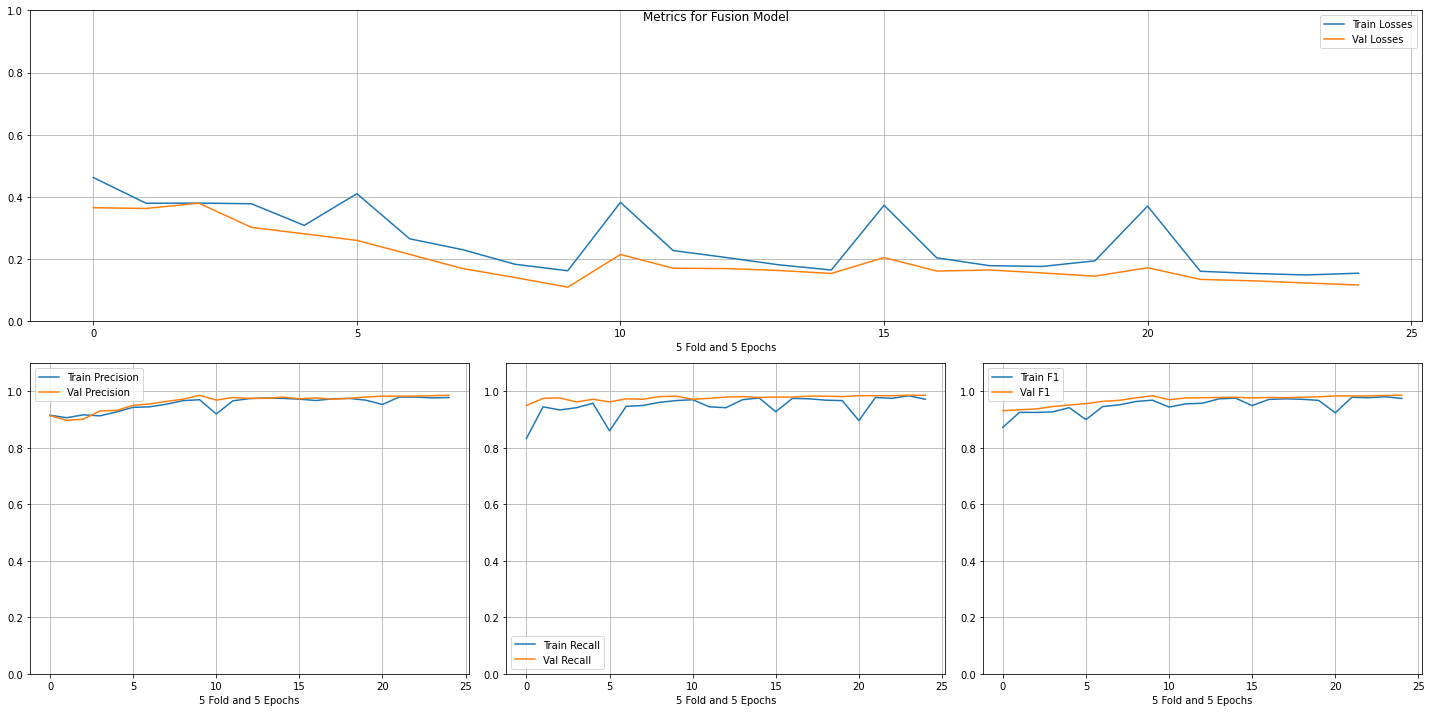

In [28]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/MBERT_Finetuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])
mbert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='chroma', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5, fsize=(12,1876))

In [29]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
4,0.974763,0.985849,0.977848,0.985849,0.971698,0.985849
3,0.980423,0.985075,0.976599,0.984301,0.984277,0.985849
4,0.968454,0.984227,0.969984,0.985782,0.966929,0.982677
1,0.978757,0.983504,0.979528,0.982732,0.977987,0.984277
2,0.977147,0.983504,0.979463,0.982732,0.974843,0.984277
0,0.923825,0.983504,0.953177,0.982732,0.896226,0.984277
4,0.967691,0.980330,0.968454,0.979560,0.966929,0.981102
3,0.971564,0.978824,0.974643,0.975000,0.968504,0.982677
4,0.975610,0.978723,0.974843,0.979495,0.976378,0.977953
3,0.973144,0.978022,0.976228,0.974961,0.970079,0.981102
